# ML Zoomcamp 2024 - Evaluation

This is part [ML Zoomcamp](!https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master) organized by [DataTalks.Club](!https://datatalks.club/). 
This is the follow-up of the previous session to learn which metrics are good for classification.  

The dataset that we used was bank-full.csv from [bank marketing](!https://archive.ics.uci.edu/static/public/222/bank+marketing.zip) dataset provided by [Moro et.al, 2011](!http://hdl.handle.net/1822/14838)<sup>1</sup>.
<br>In this dataset, our desired target for classification task will be the `y` variable - has the client subscribed a term deposit or not.

<sup>1</sup>S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.S.

# 1. Data Preparation 

* Read the data with pandas.
* Look at the data.
* Selecting the columns (based on course instruction).
* Change the target variable to be an integer - target encoding.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, auc, roc_auc_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from tqdm.autonotebook import tqdm

%matplotlib inline

C:\Users\nicko\AppData\Local\Temp\ipykernel_54816\2125432881.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('../bank/bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
df.y = (df.y == 'yes').astype(int)

In [7]:
df.corr(numeric_only=True)

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236
y,0.025155,0.052838,-0.028348,0.394521,-0.073172,0.103621,0.093236,1.000000


# 2. Setting Up The Validation Framework.
* Perform the train/validation/test split using Scikit-Learn. (60%/20%/20% distribution)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [9]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [11]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [12]:
del df_train['y']
del df_val['y']
del df_test['y']

# 3. EDA
* Check missing values.
* Look at the target variable.
* Look at numerical and categorical variables

In [13]:
df_full_train.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [14]:
df_full_train.y.value_counts(normalize=True)

y
0    0.882797
1    0.117203
Name: proportion, dtype: float64

The data train consists of 11% of customers who have subscribed to a term deposit.

In [15]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [16]:
categorical = ['job', 'marital', 'education', 'housing', 'contact','month', 'poutcome']

In [17]:
df_full_train[categorical].nunique()

job          12
marital       3
education     4
housing       2
contact       3
month        12
poutcome      4
dtype: int64

# 4. Feature Importance 
* Calculate the mutual information between `y` and other categorical variables.
* Calculate correlation with numerical variables.
* Use AUC as alternative for feature importance

In [18]:
def mutual_information(series):
    return mutual_info_score(series, df_full_train.y)

In [19]:
df_full_train[categorical].apply(mutual_information).round(2).sort_values(ascending=False)

poutcome     0.03
month        0.02
job          0.01
housing      0.01
contact      0.01
marital      0.00
education    0.00
dtype: float64

In [20]:
df_full_train[numerical].corrwith(df_full_train.y).round(3).sort_values(ascending=False)

duration    0.398
pdays       0.101
previous    0.087
balance     0.055
age         0.025
day        -0.031
campaign   -0.072
dtype: float64

In [21]:
feature_auc = {}

for feat in numerical:

    roc_auc = roc_auc_score(y_train, df_train[feat])
    feature_auc[feat] = roc_auc.round(3)

feature_auc

{'age': 0.488,
 'balance': 0.589,
 'day': 0.474,
 'duration': 0.815,
 'campaign': 0.429,
 'pdays': 0.59,
 'previous': 0.599}

# 5.  One-hot Encoding

In [22]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
train_dicts[0]

{'job': 'entrepreneur',
 'marital': 'married',
 'education': 'tertiary',
 'housing': 'no',
 'contact': 'cellular',
 'month': 'jul',
 'poutcome': 'unknown',
 'age': 56,
 'balance': 40,
 'day': 11,
 'duration': 123,
 'campaign': 2,
 'pdays': -1,
 'previous': 0}

# 6. Training Logistic Regression with Scikit-Learn
* Train a model with Scikit-Learn.
* Apply it to the validation dataset.
* Calculate the accuracy of the validation dataset.

In [24]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [25]:
y_pred = model.predict_proba(X_val)[:, 1]

In [26]:
subscribe_prediction = (y_pred >= 0.5)

# 7. Evaluation Metrics

### Accuracy

In [27]:
def accuracy(model, X_val, y_val):
    y_pred = model.predict_proba(X_val)[:, 1]
    subscribe_prediction = (y_pred >= 0.5)

    return (y_val == subscribe_prediction).mean()

In [28]:
acc = accuracy(model, X_val, y_val)
acc

0.8981420039814201

In [29]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = subscribe_prediction.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred.head()

,probability,prediction,actual,correct
0,0.029814,0,0,True
1,0.023154,0,0,True
2,0.020545,0,0,True
3,0.014901,0,0,True
4,0.026943,0,0,True


### AUC

In [30]:
roc_auc_score(y_val, y_pred)

0.9003460241728529

### Precision and Recall

Precision and recall can be computed from the confusion matrix 
![confusion matrix](confusion_matrix.png)


In [31]:
scores = [] 

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)

    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()

    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, precision, recall))

C:\Users\nicko\AppData\Local\Temp\ipykernel_54816\334549616.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [32]:
columns = ['threshold','precision', 'recall']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores

,threshold,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135480,0.996357
2,0.02,0.159121,0.995446
3,0.03,0.186963,0.989982
4,0.04,0.219020,0.969035
...,...,...,...
96,0.96,0.645833,0.028233
97,0.97,0.625000,0.022769
98,0.98,0.666667,0.018215
99,0.99,0.687500,0.010018


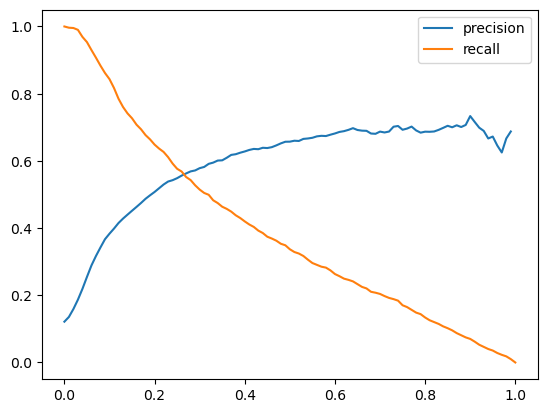

In [34]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### F1 Score

In [35]:
F1 = lambda p, r: 2 * (p * r) / (p + r)

In [36]:
df_scores['f1_score'] = F1(df_scores['precision'], df_scores['recall'])

In [37]:
df_scores[df_scores['f1_score'] == df_scores.f1_score.max()]

,threshold,precision,recall,f1_score
22,0.22,0.529638,0.626594,0.574051


# 7. Cross Validation
* Iterate over different folds of the training dataset
* Use AUC to evaluate the model

In [38]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [39]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [40]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = [] 

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'AUC mean: {np.mean(scores)} | AUC std: {np.std(scores)}')

0it [00:00, ?it/s]

AUC mean: 0.9060551905028035 | AUC std: 0.005656168836598589


# 8. Hyperparameter Training 
* train using different regularisation values `C`
* check which `C` gave the best AUC score  

In [41]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = [] 

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C: {C} | AUC mean: {np.mean(scores).round(3)} | AUC std: {np.std(scores).round(3)}')

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C: 1e-06 | AUC mean: 0.701 | AUC std: 0.009


0it [00:00, ?it/s]

C: 0.001 | AUC mean: 0.861 | AUC std: 0.007


0it [00:00, ?it/s]

C: 1 | AUC mean: 0.906 | AUC std: 0.006


# 9. Summary

In this module, we learn about metrics for classification. 

A metric is a single number that describes the performance of a model.

Accuracy can be misleading, especially when we have an imbalanced dataset. Therefore, there are several other metrics that can be used, i.e. precision, recall, F1 score, ROC AUC 

Besides holding a part of the dataset as a validation dataset, we can use `K-Fold` cross-validation, where we split the data into a `K` number of folds and train and validate across different folds.